# Taxi Cab Trips Exploratory Data Analysis

In [1]:
import pandas as pd, seaborn as sns, numpy as np
from scipy import stats
from matplotlib import pyplot as plt

In [2]:
df = pd.read_csv("taxicab_prepped.csv")
df.head()

,VendorID,hour,rush_hour,day,month,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,subtotal,total_amount
0,2,8,0,saturday,march,6,3.34,1,100,231,1,13.0,13.8,16.56
1,1,14,0,tuesday,april,1,1.80,1,186,43,1,16.0,16.8,20.80
2,1,7,1,friday,december,1,1.00,1,262,236,1,6.5,7.3,8.75
3,2,13,0,sunday,may,1,3.70,1,188,97,1,20.5,21.3,27.69
4,2,23,0,saturday,april,1,4.37,1,4,112,2,16.5,17.8,17.80


# Vendor ID

Now lets look at the vendor types, according to the data manual there are two vendor types and they correspond to the provider of the record or trip data. Let's look to see which provider has more or less expensive services

        1= Creative Mobile Technologies, LLC;

        2= VeriFone Inc.

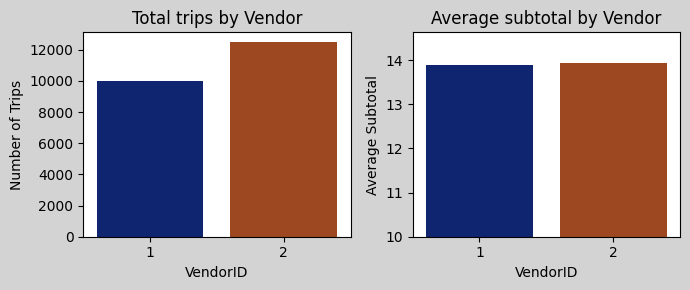

In [3]:
vendor_counts = df['VendorID'].value_counts()
vendor_costs = df.groupby('VendorID')['subtotal'].mean()

# Create subplots for vendor counts and average subtotal by vendor
fig, axes = plt.subplots(1, 2, figsize=(7, 3))
fig.patch.set_facecolor('lightgrey')

# Plot for total trips by vendor
sns.barplot(x=vendor_counts.index, y=vendor_counts.values, palette='dark', hue = vendor_counts.index, legend = False, ax=axes[0])
axes[0].set_title('Total trips by Vendor')
axes[0].set_xlabel('VendorID')
axes[0].set_ylabel('Number of Trips')

# Plot for average subtotal by vendor
sns.barplot(x=vendor_costs.index, y=vendor_costs.values, palette='dark', hue = vendor_costs.index, legend = False, ax=axes[1])
axes[1].set_title('Average subtotal by Vendor')
axes[1].set_xlabel('VendorID')
axes[1].set_ylabel('Average Subtotal')
axes[1].set_ylim(10)

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

There average cost of a trip is nearly identicle (notice the lower limit on the chart is set to 10, so the tiny difference that is visble is only an illusion) no matter which vendor you happen to choose, however in the chart on the left it seems that Vendor 2 (Verifone) is chosen most often, this could be due to any number of reason, some likely reasons being better ride quality, or the company has more units on the street so there is increased availablity.

# Hour & Rush Hour

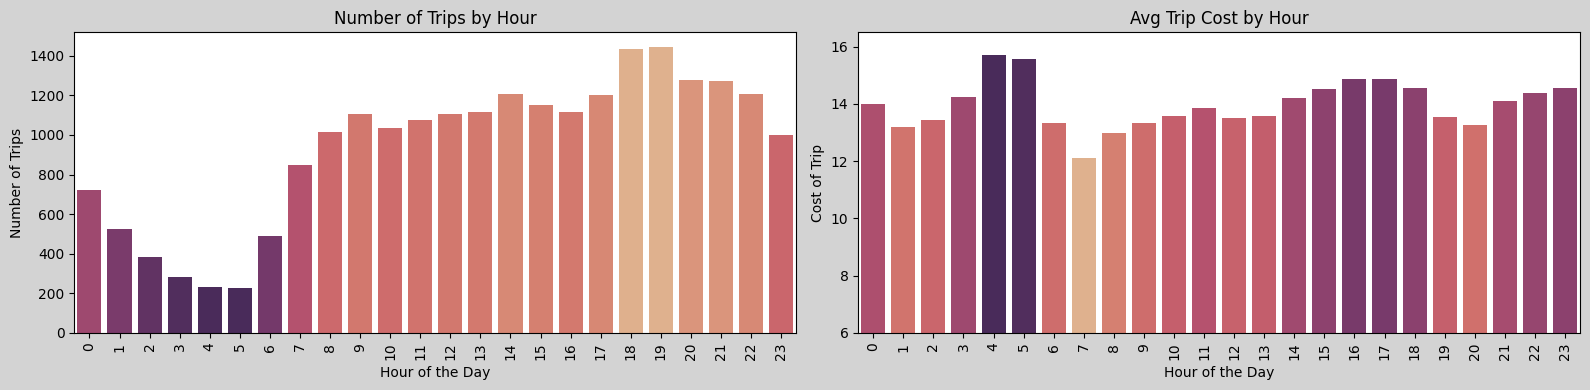

In [4]:
by_hour_counts = df["hour"].value_counts().sort_index(ascending=False)
by_hour_costs = df.groupby("hour")["subtotal"].mean()

# Plotting a bar chart
fig, axes = plt.subplots(1, 2, figsize=(16, 4))
fig.patch.set_facecolor('lightgrey')

# Plot the first chart
sns.barplot(x=by_hour_counts.index, y=by_hour_counts.values, palette='flare_r', hue = by_hour_counts.values, legend = False, ax=axes[0])
axes[0].set_title('Number of Trips by Hour')
axes[0].set_xlabel('Hour of the Day')
axes[0].set_ylabel('Number of Trips')
axes[0].tick_params(axis='x', rotation=90)  # Rotate x-axis labels for better readability

# Plot the second chart (copy of the first one)
sns.barplot(x=by_hour_costs.index, y=by_hour_costs.values, palette='flare', hue = by_hour_costs.values, legend = False, ax=axes[1])
axes[1].set_title('Avg Trip Cost by Hour')
axes[1].set_xlabel('Hour of the Day')
axes[1].set_ylabel('Cost of Trip')
axes[1].set_ylim(6)
axes[1].tick_params(axis='x', rotation=90)  # Rotate x-axis labels for better readability

plt.tight_layout()
plt.show()

From the chart on the left we can see unsurprisingly that the hours of midnight to 6am are the hours with the least volume of rides, and that the afternoon rush hour has the most volume. When we compare both charts we see that the avg trip cost varies unpredictably with the exception of 4 and 5am, which are the two hours with the least volume, so we can expect that some form of premium is charged during these hours, likely the overnight premium mentioned in the description of the "extra" column, but just to be sure let's check if longer rides are taken during these hours that would explain the variance in cost.

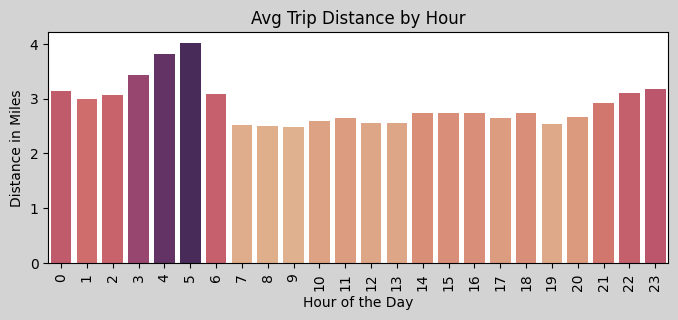

In [5]:
by_hour_distance = df.groupby("hour")["trip_distance"].mean()

plt.figure(figsize=(8, 3))
plt.gcf().set_facecolor('lightgrey')

# Plot the bar chart
sns.barplot(x=by_hour_distance.index, y=by_hour_distance.values, palette='flare', hue = by_hour_distance.values, legend = False)
plt.title('Avg Trip Distance by Hour')
plt.xlabel('Hour of the Day')
plt.ylabel('Distance in Miles')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability

plt.show()

So it seems that longer trips are more likely to be booked in the morning, which helps in explaining why trips around this time cost more on average.

Now let's look at rush hour, and see if it can tell us anything, but ffirst we will make a temporary dataframe that excludes Saturday and Sunday since these days do not include rush hour.

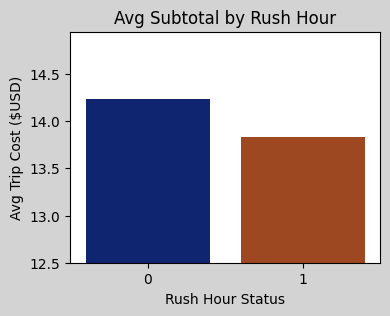

rush_hour
0    14.234199
1    13.835181
Name: subtotal, dtype: float64


In [6]:
# Seperate out the weekends so that a comparison can be made on rush_hour using only weekdays
df_no_weekends = df[(df["day"] != "saturday") & (df["day"] != "sunday")]

rush_hour_costs = df_no_weekends.groupby("rush_hour")["subtotal"].mean()

plt.figure(figsize=(4, 3))
plt.gcf().set_facecolor('lightgrey')
sns.barplot(x=rush_hour_costs.index, y=rush_hour_costs.values, palette="dark", hue = rush_hour_costs.index, legend= False)
plt.ylim(12.5)
plt.ylabel("Avg Trip Cost ($USD)")
plt.title("Avg Subtotal by Rush Hour")
plt.xlabel("Rush Hour Status")
plt.show()

print(rush_hour_costs)

It appears that the column for rush_hour holds no predictive power since the avg cost during rush hour is *less* than non-rush-hour hours.

**IN CONCLUSION...** with reguards to the hour feature, there is a clear and noticable spike in cost during the hours of 4-5am, and then price falls significantly and slowly rises thoughout the day, we could encode a binary variable for if a ride is being taken during the two hours of note, and remove the column rush_hour since it has proven irrelevant.

# Day & Month

Let's see do some quick analysis of these new variables and see if the final total of rides varies by the value of our new columns

In [27]:
day_order = ["monday", "tuesday", "wednesday", "thursday", "friday", "saturday", "sunday"]
month_order = ["january", "february", "march", "april", "may", "june", "july", "august", "september", "october", "november", "december"]


daily_counts = df["day"].value_counts().reindex(day_order)
daily_costs = df.groupby("day")["subtotal"].mean()
daily_costs = daily_costs.reindex(day_order)

monthly_counts = df["month"].value_counts().reindex(month_order)
monthly_costs = df.groupby("month")["subtotal"].mean()
monthly_costs = monthly_costs.reindex(month_order)

month
january      13.462663
february     13.674949
march        13.742537
april        13.673871
may          14.485180
june         14.134724
july         13.766767
august       13.912569
september    13.850712
october      13.960862
november     14.230055
december     14.056227
Name: subtotal, dtype: float64


C:\Users\admin\AppData\Local\Temp\ipykernel_25520\2226037892.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0,0].set_xticklabels(axes[0,0].get_xticklabels(), rotation=45)
C:\Users\admin\AppData\Local\Temp\ipykernel_25520\2226037892.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0,1].set_xticklabels(axes[0,1].get_xticklabels(), rotation=45)
C:\Users\admin\AppData\Local\Temp\ipykernel_25520\2226037892.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1,0].set_xticklabels(axes[1,0].get_xticklabels(), rotation=45)
C:\Users\admin\AppData\Local\Temp\ipykernel_25520\2226037892.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[

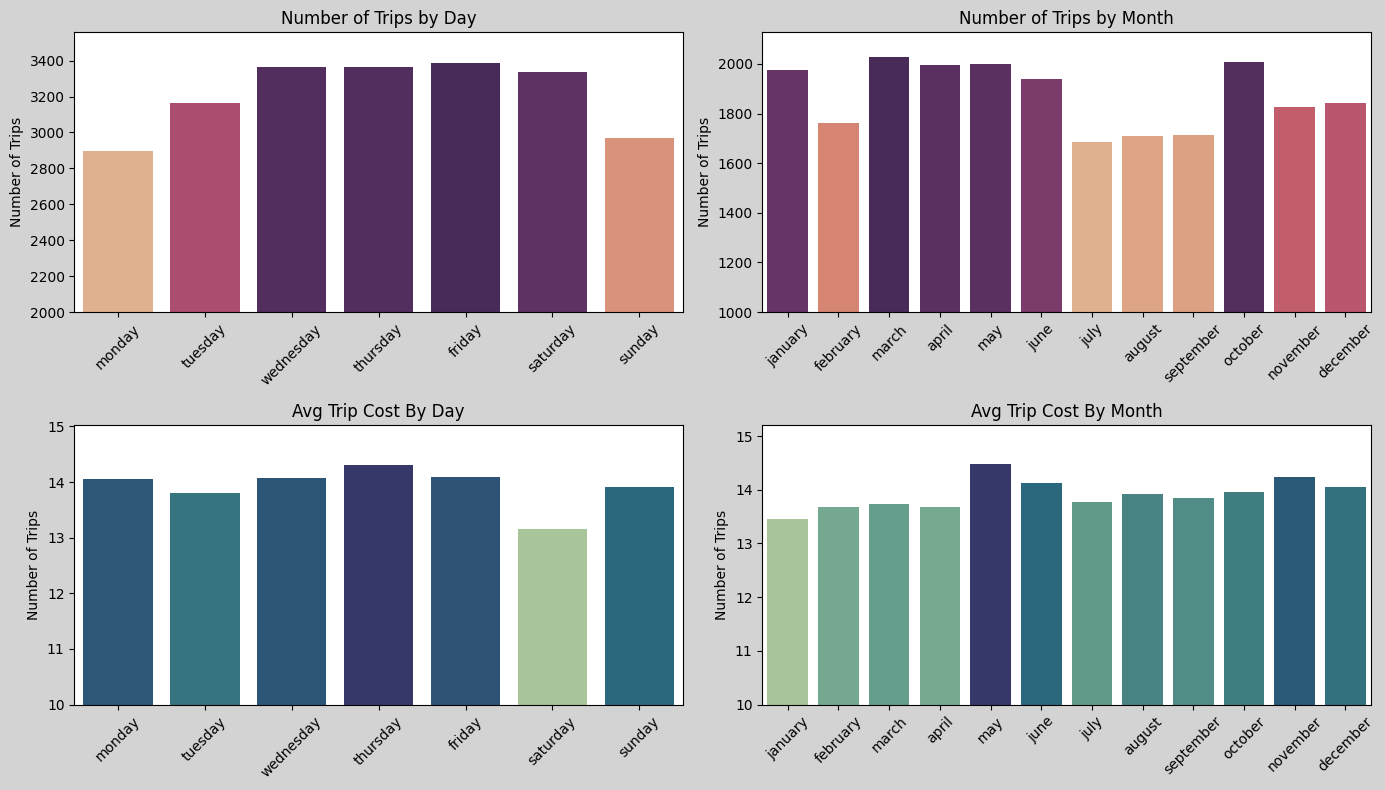

In [36]:
fig, axes = plt.subplots(2, 2, figsize=(14, 8))
fig.patch.set_facecolor('lightgrey')

sns.barplot(x=daily_counts.index, y=daily_counts.values, ax=axes[0,0], palette = "flare", hue = daily_counts.values, legend= False)
axes[0,0].set_title("Number of Trips by Day")
axes[0,0].set_xlabel('') 
axes[0,0].set_ylabel("Number of Trips")
axes[0,0].set_ylim(2000) 
axes[0,0].set_xticklabels(axes[0,0].get_xticklabels(), rotation=45)

sns.barplot(x=monthly_counts.index, y=monthly_counts.values, ax=axes[0,1], palette = "flare", hue = monthly_counts.values, legend= False)
axes[0,1].set_title("Number of Trips by Month")
axes[0,1].set_xlabel('') 
axes[0,1].set_ylabel("Number of Trips")
axes[0,1].set_ylim(1000) 
axes[0,1].set_xticklabels(axes[0,1].get_xticklabels(), rotation=45)

sns.barplot(x=daily_costs.index, y=daily_costs.values, ax=axes[1,0], palette = "crest", hue = daily_costs.values, legend= False)
axes[1,0].set_title("Avg Trip Cost By Day")
axes[1,0].set_xlabel('') 
axes[1,0].set_ylabel("Number of Trips")
axes[1,0].set_ylim(10) 
axes[1,0].set_xticklabels(axes[1,0].get_xticklabels(), rotation=45)

sns.barplot(x=monthly_costs.index, y=monthly_costs.values, ax=axes[1,1], palette = "crest", hue = monthly_costs.values, legend= False)
axes[1,1].set_title("Avg Trip Cost By Month")
axes[1,1].set_xlabel('') 
axes[1,1].set_ylabel("Number of Trips")
axes[1,1].set_ylim(10) 
axes[1,1].set_xticklabels(axes[1,1].get_xticklabels(), rotation=45)

# Adjust layout
plt.tight_layout()
plt.show()

# Passenger Count

We can see that the average total_amount by vendors are nearly identical, let's see now if there is any change in total amount for different numbers of passengers.

In [10]:
avg_total_amount = df.groupby("passenger_count")["total_amount"].mean()
avg_tip_amount = df.groupby("passenger_count")["tip_amount"].mean()

plt.figure(figsize=(10, 4))

# Plot Mean Total Amount by Passenger Count
plt.subplot(1,2,1)
sns.barplot(x=avg_total_amount.index, y=avg_total_amount.values, color="tab:red")
plt.ylim(15)
plt.xlabel('Passenger Count')
plt.ylabel('Mean Total Amount')
plt.title('Mean Total Amount by Passenger Count')

# Plot Mean Tip Amount by Passenger Count
plt.subplot(1,2,2)
sns.barplot(x=avg_tip_amount.index, y=avg_tip_amount.values, color="tab:orange")
plt.ylim(1.25)
plt.xlabel('Passenger Count')
plt.ylabel('Mean Tip Amount')
plt.title('Mean Tip Amount by Passenger Count')

plt.tight_layout()  # Adjust subplots to fit nicely in the figure
plt.show()

KeyError: 'Column not found: tip_amount'

We see no real discernable difference in the total amounts by different numbers of passengers (Note the Y-axes are regularized for a better display, and the differences in the data are much less percievable than they appear in the graphs above), if anything, total_amount peaks and decreases after 2 passengers and oddly enough trips with no passengers are the most expensive on average. This could once again be an error in the dataset that needs investigation, however it's also noted that this only occurs 33 times, and could likely be an event such as a driver being paid to deliver a package for someone, and not actually transporting a rider. Inquiry with the drivers would be necessary for these 33 points, otherwise complete omission from the dataset could perhaps be wise. 

# Trip Distance

Now let's see the effect trip_distance has on total_amount, but first we'll have to seperate the tens of thousands of rows into a more usable format, so we'll split it into 11 new groups based off trip_distance, then find the mean of total amount for each group and plot another bar chart.

In [ ]:
bins = [0.0]
for i in range(1,11):
    bins.append(i/10)

quantiles = []
for i in bins:
    quantiles.append(df['trip_distance'].quantile(i))        
quantiles.sort()
print(quantiles)

df['group'] = pd.cut(df['trip_distance'], bins=quantiles, include_lowest=True, right=True, duplicates='drop')
avg_ta_trip_dist = df.groupby('group', observed=False)['total_amount'].mean()
print(avg_ta_trip_dist)

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))

# Plot histogram using Seaborn on the first subplot
sns.histplot(df["trip_distance"], bins=25, color="tab:orange", ax=axes[0])
axes[0].set_xlabel('Trip Distance (In Miles)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Trip Distance Frequencies')

# Plot bar chart using Seaborn on the second subplot
avg_ta_trip_dist_keys = avg_ta_trip_dist.index.tolist()
avg_ta_trip_dist_values = avg_ta_trip_dist.values.tolist()
sns.barplot(x=avg_ta_trip_dist_keys, y=avg_ta_trip_dist_values, color="tab:red", ax=axes[1])
axes[1].set_xticklabels(avg_ta_trip_dist_keys, rotation=45, ha="right")
axes[1].set_xlabel('Trip Distance (In Miles)')
axes[1].set_ylabel('Mean Total Amount')
axes[1].set_title('Mean Total Amount by Trip Distance')

# Adjust layout and display the figure
plt.tight_layout()
plt.show()

print(f'Number of rides with distance of 0 miles: ' + str(sum(df['trip_distance']==0)))

As expected we see a gradual increase in trip distance to the total cost (it looks exponential only because there are trips with oulier distances as shown in the left hand graph) this relationship will be important to know later when we intend to predict the cost of a trip before it is taken, likely we will use machine learning to get as close to exact predictions on this relationship. It is also noted that there is a number of rides (148) that have a distance of 0, this could be due to any number of errors in the data entry however since the number of errors in this case (148 / 22000+) is relatively small. We will elect to not worry about thier effect on the final model that gets created.

## Payment Type

In [ ]:
df.sort_values(by="total_amount", ascending=False).tail(15)

,Unnamed: 0,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,...,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,duration,day,month,rush_hour
5722,49670364,2,2017-06-12 12:08:55,2017-06-12 12:08:57,1,0.00,1,N,264,193,...,0.0,0.0,0.0,0.0,0.0,0.0,0.033333,monday,june,0
4402,108016954,2,2017-12-20 16:06:53,2017-12-20 16:47:50,1,7.06,1,N,263,169,...,0.0,0.0,0.0,0.0,0.0,0.0,40.950000,wednesday,december,1
1646,57337183,2,2017-07-05 11:02:23,2017-07-05 11:03:00,1,0.04,1,N,79,79,...,0.0,-0.5,0.0,0.0,-0.3,-3.3,0.616667,wednesday,july,0
5758,833948,2,2017-01-03 20:15:23,2017-01-03 20:15:39,1,0.02,1,N,170,170,...,-0.5,-0.5,0.0,0.0,-0.3,-3.8,0.266667,tuesday,january,0
314,105454287,2,2017-12-13 02:02:39,2017-12-13 02:03:08,6,0.12,1,N,161,161,...,-0.5,-0.5,0.0,0.0,-0.3,-3.8,0.483333,wednesday,december,0
18565,43859760,2,2017-05-22 15:51:20,2017-05-22 15:52:22,1,0.10,1,N,230,163,...,0.0,-0.5,0.0,0.0,-0.3,-3.8,1.033333,monday,may,0
10281,55302347,2,2017-06-05 17:34:25,2017-06-05 17:36:29,2,0.00,1,N,238,238,...,-1.0,-0.5,0.0,0.0,-0.3,-4.3,2.066667,monday,june,1
4423,97329905,2,2017-11-16 20:13:30,2017-11-16 20:14:50,2,0.06,1,N,237,237,...,-0.5,-0.5,0.0,0.0,-0.3,-4.3,1.333333,thursday,november,0
5448,28459983,2,2017-04-06 12:50:26,2017-04-06 12:52:39,1,0.25,1,N,90,68,...,0.0,-0.5,0.0,0.0,-0.3,-4.3,2.216667,thursday,april,0
8204,91187947,2,2017-10-28 20:39:36,2017-10-28 20:41:59,1,0.41,1,N,236,237,...,-0.5,-0.5,0.0,0.0,-0.3,-4.8,2.383333,saturday,october,0


We notice that all of the negative total amounts coincide with payments with methods 3 and 4, which when referencing the data manual are "No charge" and "Dispute" respectviely, so the negative values may not be an error after all, but more investigation is warranted. Let's see how common each payment type is.

In [ ]:
print(f'payment_type Frequencies {df["payment_type"].value_counts()}')
print("\nAverage tip_amount by payment type")
print(df.groupby("payment_type")["tip_amount"].mean())

payment_type Frequencies payment_type
1    15102
2     7188
3      118
4       45
Name: count, dtype: int64

Average tip_amount by payment type
payment_type
1    2.613121
2    0.000000
3    0.000000
4    0.000000
Name: tip_amount, dtype: float64


It seems "Credit Card" is by far the most popular, followed by "Cash", and then followed by "No Charge" and "Dispute" with reltatively little frequency. It's noted that there are two more types 5 and 6, "Uknown" and "Voided Trip" respectively, that never occur in this dataset. When looking at the average tip amounts by the payment method, we see that only those that pay with credit cards tip, and all other methods have an average of 0. Let's see how many tips there are in the data set to get a sense if there may be an error or if tipping taxi drivers is just uncommon in NYC.

In [ ]:
number_tips = df["tip_amount"][(df["tip_amount"].notna()) & (df["tip_amount"] > 0)].count()
total_rows = len(df)

print(f'(Total Rows = {total_rows}) - (Rows with Tips = {number_tips}) = {total_rows-number_tips}')

(Total Rows = 22453) - (Rows with Tips = 14494) = 7959


With nearly 15000 tips in the data set, supposedly all of them are from people paying by credit card, that makes a 14642/15265 = 96% tip rate by those with credit cards and a 0% rate for all other methods. Some investigation will need to be done reguarding if this is just a quirk with how credit cards are used, perhaps a tip is automatically applied in most cases with an option to select no tip, this would explain the high tip rate among credit card users. Perhaps also cash tips are not recorded by the drivers and instead just pocketed directly for any number of reasons, but this is only speculation. (Upon closer inspection of the data manual, both of the above reasons were true)

Let's now see if we can gain any insight into the cost of the trip based on the payent_type used by the rider. Since we already know that the final_amount metric is biased due to the omission of cash tips, lets instead look at the fare amount for any information.

In [ ]:
df.groupby("payment_type")["fare_amount"].mean()[:2]

payment_type
1    12.855516
2    11.747565
Name: fare_amount, dtype: float64

It seems that those that pay with credit card end up paying roughly $1.20 more on their fares. let's conduct a hypothesis test to see if this is an statitsically relevant insight.

For our h-test we will use a two sample t-test and a significance level of 5% or 0.05. And our hypotheses will be:

H_o will be that there is no difference in the average fare amount by payment type.

H_a will be that there is a difference in the average fare amount by payment type.

In [ ]:
card = df[df["payment_type"] == 1]
cash = df[df["payment_type"] == 2]

stats.ttest_ind(a = card["fare_amount"], b = cash["fare_amount"], equal_var=False)

TtestResult(statistic=8.176034477651516, pvalue=3.169157590321286e-16, df=14835.427831110026)

The resulting p-value is very small; meaning that we can reject the null hypothesis and must accept that there is a significant difference in the average fare_amount charged to those paying by credit cards versus those paying by cash, suggesting that it would be wise to encode a binary variable in the final model to capture this information.

# ADD SECTION PROVING ASSUMPTIONS FOR LIN_REG

# ANALYSIS ON PICKUP/DROPOFF

# ANALYSIS ON DAY AND MONTH AND RUSH_HOUR COLUMNS

In [ ]:
df.head()

,Unnamed: 0,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,...,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,duration,day,month,rush_hour,group
0,24870114,2,2017-03-25 08:55:43,2017-03-25 09:09:47,6,3.34,1,N,100,231,...,0.5,2.76,0.0,0.3,16.56,14.066667,saturday,march,0,"(2.6, 3.6]"
1,35634249,1,2017-04-11 14:53:28,2017-04-11 15:19:58,1,1.80,1,N,186,43,...,0.5,4.00,0.0,0.3,20.80,26.500000,tuesday,april,0,"(1.6, 2.0]"
2,106203690,1,2017-12-15 07:26:56,2017-12-15 07:34:08,1,1.00,1,N,262,236,...,0.5,1.45,0.0,0.3,8.75,7.200000,friday,december,1,"(0.87, 1.1]"
3,38942136,2,2017-05-07 13:17:59,2017-05-07 13:48:14,1,3.70,1,N,188,97,...,0.5,6.39,0.0,0.3,27.69,30.250000,sunday,may,0,"(3.6, 6.42]"
4,30841670,2,2017-04-15 23:32:20,2017-04-15 23:49:03,1,4.37,1,N,4,112,...,0.5,0.00,0.0,0.3,17.80,16.716667,saturday,april,0,"(3.6, 6.42]"


In [ ]:
df["PULocationID"].nunique()
df["DOLocationID"].nunique()

212